In [ ]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')
import tensorflow as tf
from nltk.corpus import stopwords
import requests
import os
import re
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import urllib.request
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.9.1
2.17.1
2.2.2


In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
data.sample(10)

,headlines,text
27193,Italian club's share rises 20% over Ronaldo's ...,Italian club Juventus' shares rose 20% amid re...
6519,"He's the lucky one, not me: Katrina on being S...","Actress Katrina Kaif, on being asked if she co..."
73418,IS seeks negotiations to withdraw from Syria-L...,ISIS has asked the Syrian Army and Hezbollah t...
31320,Ex-VP Ansari supports AMU students in Jinnah p...,Former Vice President Hamid Ansari has said th...
82893,T'gana hospital turns away pregnant women sayi...,Several pregnant women protested outside a gov...
86438,US-backed Syrian forces retake 'Freedom Dam' f...,US-backed Syrian militias have reportedly reca...
53759,8 Meghalaya MLAs join BJP ally days after resi...,"Eight Meghalaya MLAs, who had quit the state A..."
75411,Oxygen dearth not among UP govt's 23 reasons f...,The Uttar Pradesh government's record for the ...
92911,'Sleeping Beauty' mummy appears to blink,"The mummy of a two-year-old Italian girl, Rosa..."
75323,Brazilian footballer Kaka sent off for joking ...,Brazilian footballer Kaka was sent off for all...


### 데이터 전처리하기(추상적 요약)

In [ ]:
len(data['text'])

98401

In [ ]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [ ]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [ ]:
data.isnull().sum()

,0
headlines,0
text,0


In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
# def preprocess_sentence(sentence, remove_stopwords=True):
#     sentence = sentence.lower()  # 텍스트 소문자화
#     sentence = BeautifulSoup(sentence, "lxml").text  # HTML 문법 제거
#     sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호 안에 문자열 제거
#     sentence = re.sub('"', '', sentence)  # 쌍따옴표 제거
#     sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # 약어 정규화
#     sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거
#     sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자 제거
#     sentence = re.sub('[m]{2,}', 'mm', sentence)  # m이 3개 이상이면 2개로 변경
#     sentence = re.sub('\s+', ' ', sentence).strip()  # 연속된 공백 제거
#     sentence = ' '.join([word for word in sentence.split() if len(word) <= 20])  # 단어 길이 제한
#     sentence = re.sub(r'\b(\w+)( \1\b)+', r'\1', sentence)  # 중복 단어 제거
#     if remove_stopwords:
#         tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
#     else:
#         tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
#     return tokens

* EX)

In [ ]:
temp_text = 'Everything I bought was great, infact<I> <ordered twice and the third ordered was<br />for my mother and father.. Father. fffffffffffffffffffffffff'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))

text:  everything bought great infact mother father father fffffffffffffffffffffffff
summary: great way to start the day


In [ ]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
clean_text = []

# [[YOUR CODE]]

clean_text = data['text'].apply(lambda x: preprocess_sentence(x) if pd.notnull(x) else "")


# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: text, dtype: object


In [ ]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_headlines = []

# [[YOUR CODE]]

clean_headlines = data['headlines'].apply(lambda x: preprocess_sentence(x,remove_stopwords=False) if pd.notnull(x) else "")
print("headlines 전처리 후 결과: ", clean_headlines[:5])

<ipython-input-10-1466dbc68293>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


headlines 전처리 후 결과:  0    upgrad learner switches to career in ml al wit...
1    delhi techie wins free food from swiggy for on...
2    new zealand end rohit sharma led india match w...
3    aegon life iterm insurance plan helps customer...
4    have known hirani for yrs what if metoo claims...
Name: headlines, dtype: object


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
제목의 최소 길이 : 1
제목의 최대 길이 : 18
제목의 평균 길이 : 9.553660024400163


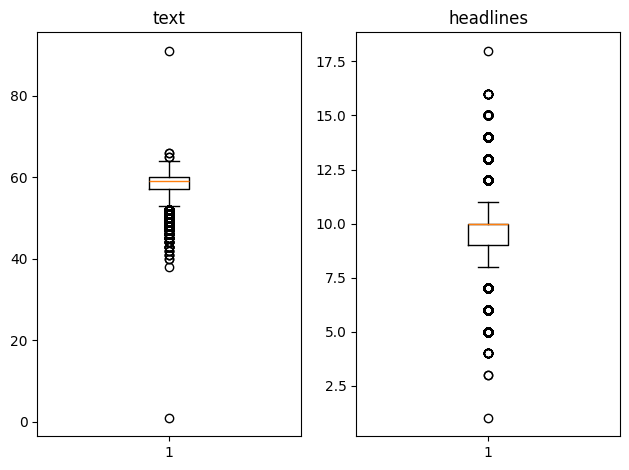

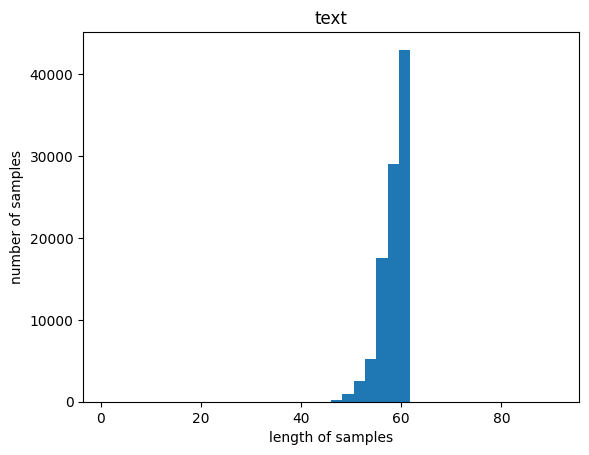

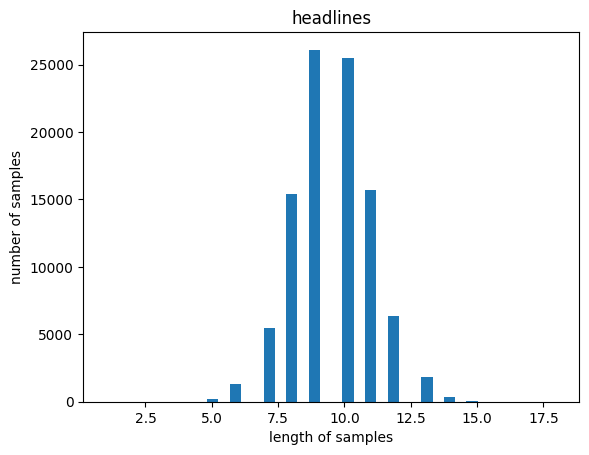

In [ ]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('제목의 최소 길이 : {}'.format(np.min(summary_len)))
print('제목의 최대 길이 : {}'.format(np.max(summary_len)))
print('제목의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [ ]:
data.isnull().sum()

,0
headlines,0
text,0


In [ ]:
text_max_len = 50
summary_max_len = 12

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [ ]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [ ]:
# 굳이 할 필요 없을 것 같긴한데...
# text 열에서 단어 시퀀스 길이 제한
data['text'] = data['text'].apply(lambda s: ' '.join(s.split()[:text_max_len]) if pd.notnull(s) else s)

# headlines 열에서 단어 시퀀스 길이 제한
data['headlines'] = data['headlines'].apply(lambda s: ' '.join(s.split()[:summary_max_len]) if pd.notnull(s) else s)

In [ ]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [ ]:
# 제목에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [ ]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [ ]:
# 셔플
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[49170 94366 26217 ...  5447 54491 59376]


In [ ]:
# 동일하게
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
import math

In [ ]:
src_tokenizer = Tokenizer(oov_token='<UNK>') # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input) # 입력된 데이터로부터 단어 집합 생성

In [ ]:
threshold = 6
total_cnt = len(src_tokenizer.word_index)  # 단어 집합 크기
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어 개수
total_freq = 0  # 전체 단어 빈도수 총합
rare_freq = 0  # 희귀 단어 빈도수 총합

# 전체 문서 수 (예: 샘플 수)
total_documents = len(encoder_input)
# 결과 저장용 리스트
freq_inverse_freq_data = []

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    # 전체 빈도수 합계
    total_freq += value

    # 희귀 단어 체크
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

    # 빈도-역빈도 계산 (TF와 IDF 추가)
    tf = value / total_freq  # Term Frequency (TF)
    idf = math.log((total_documents + 1) / (value + 1))  # Inverse Document Frequency (IDF)
    tf_idf = tf * idf  # TF-IDF 계산

    # 빈도, 역빈도, TF-IDF 데이터 저장
    inverse_frequency = 1 / value
    freq_inverse_ratio = value * inverse_frequency
    freq_inverse_freq_data.append((key, value, inverse_frequency, freq_inverse_ratio, tf, idf, tf_idf))

# 결과 출력
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : %s' % (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율 :", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq / total_freq) * 100)

# 빈도-역빈도 데이터프레임 생성
import pandas as pd
freq_df = pd.DataFrame(freq_inverse_freq_data, columns=[
    "word", "frequency", "inverse_frequency", "freq_inverse_ratio", "TF", "IDF", "TF-IDF"
])

# 상위 몇 개 단어를 출력
print(freq_df.head())

단어 집합(vocabulary)의 크기 : 76334
등장 빈도가 5번 이하인 희귀 단어의 수: 49801
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : 26533
단어 집합에서 희귀 단어의 비율 : 65.24091492650719
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 2.6905613977664586
       word  frequency  inverse_frequency  freq_inverse_ratio        TF  \
0  commerce        841           0.001189                 1.0  1.000000   
1  minister       9639           0.000104                 1.0  0.919752   
2    suresh        285           0.003509                 1.0  0.026475   
3    prabhu        138           0.007246                 1.0  0.012657   
4      said      53871           0.000019                 1.0  0.831676   

        IDF    TF-IDF  
0  4.760620  4.760620  
1  2.322723  2.136329  
2  5.840408  0.154623  
3  6.561926  0.083055  
4  0.602034  0.500697  


##### **1차 시도에선 데이터셋을 분리시키고 단어집합을 만들었다.**
  * 예측 값들이 UNK로 난무하더라.

##### **2차 시도에선 분리 전에 데이터셋을 만들었으나 디코더에서 input만을 활용하는 바람에 eostoken이 학습에 쓰이질 못 했다.**
  * eostoken이 자꾸 없다고 오류가 나는데 머리가 과열되어서 decoder input이랑 decoder tarket에 차이점을 잡아내지 못 했다.

##### **3차 시도에서야 아래와 같은 코드를 추가해서 조정하였다.**
  * ...젠장

In [ ]:
data['decoder_conbined'] = data['headlines'].apply(lambda x : 'sostoken '+ x + ' eostoken')
decoder_conbined = np.array(data['decoder_conbined'])
decoder_conbined = decoder_conbined[indices]

In [ ]:
tar_tokenizer = Tokenizer(oov_token='<UNK>')
tar_tokenizer.fit_on_texts(decoder_conbined)

In [ ]:
data['decoder_conbined']

,decoder_conbined
0,sostoken upgrad learner switches to career in ...
1,sostoken delhi techie wins free food from swig...
2,sostoken new zealand end rohit sharma led indi...
3,sostoken aegon life iterm insurance plan helps...
4,sostoken have known hirani for yrs what if met...
...,...
98396,sostoken crpf jawan axed to death by maoists i...
98397,sostoken first song from sonakshi sinha noor t...
98398,sostoken the matrix film to get reboot reports...
98399,sostoken snoop dogg aims gun at clown dressed ...


In [ ]:
data['decoder_conbined'].str.endswith('eostoken').value_counts()

,count
decoder_conbined,
True,98360


###### 빈도, 역빈도, TF-IDF 에서 인사이트 추출을 시도하고 싶었으나 무리 잠이 부족하다.

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index)  # 단어 집합 크기
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어 개수
total_freq = 0  # 전체 단어 빈도수 총합
rare_freq = 0  # 희귀 단어 빈도수 총합

# 전체 문서 수 (예: 샘플 수)
total_documents = len(decoder_conbined)
# 결과 저장용 리스트
freq_inverse_freq_data = []

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    # 전체 빈도수 합계
    total_freq += value

    # 희귀 단어 체크
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

    # 빈도-역빈도 계산 (TF와 IDF 추가)
    tf = value / total_freq  # Term Frequency (TF)
    idf = math.log((total_documents + 1) / (value + 1))  # Inverse Document Frequency (IDF)
    tf_idf = tf * idf  # TF-IDF 계산

    # 빈도, 역빈도, TF-IDF 데이터 저장
    inverse_frequency = 1 / value
    freq_inverse_ratio = value * inverse_frequency
    freq_inverse_freq_data.append((key, value, inverse_frequency, freq_inverse_ratio, tf, idf, tf_idf))

# 결과 출력
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : %s' % (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율 :", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq / total_freq) * 100)

# 빈도-역빈도 데이터프레임 생성
import pandas as pd
freq_df = pd.DataFrame(freq_inverse_freq_data, columns=[
    "word", "frequency", "inverse_frequency", "freq_inverse_ratio", "TF", "IDF", "TF-IDF"
])

# 상위 몇 개 단어를 출력
print(freq_df.head())

단어 집합(vocabulary)의 크기 : 32536
등장 빈도가 5번 이하인 희귀 단어의 수: 20908
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : 11628
단어 집합에서 희귀 단어의 비율 : 64.26112613720187
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 3.6273467622788367
       word  frequency  inverse_frequency  freq_inverse_ratio        TF  \
0  sostoken      98360           0.000010                 1.0  1.000000   
1   working        293           0.003413                 1.0  0.002970   
2        to      31359           0.000032                 1.0  0.241201   
3     raise        185           0.005405                 1.0  0.001421   
4     share        178           0.005618                 1.0  0.001365   

        IDF    TF-IDF  
0  0.000000  0.000000  
1  5.812820  0.017264  
2  1.143111  0.275719  
3  6.270653  0.008910  
4  6.309014  0.008614  


### 하도 당한게 많아서 재차 검증했다. eostoken과 sostoken이 각각 잘 들어가서 빈도 최상에 위치한 것을 확인할 수 있었다.
* 0번과 10번이다.

In [ ]:
freq_df['word'].head(15)

,word
0,sostoken
1,working
2,to
3,raise
4,share
5,of
6,exports
7,in
8,gdp
9,govt


In [ ]:
freq_df['frequency'].sort_values()

,frequency
32501,1
32502,1
32503,1
32504,1
32505,1
...,...
123,15331
7,26504
2,31359
0,98360


In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [ ]:
# 데이터 분리 전에 집합생성을 했어야!!!
src_vocab = 25000  #  text 단어집합 제한
tar_vocab = 10000   # headlines 단어집합 제한

# 인코더 입력 데이터(text) 기반 어휘 사전 생성
src_tokenizer = Tokenizer(num_words=src_vocab, oov_token='<UNK>')
src_tokenizer.fit_on_texts(encoder_input)

# 디코더 입력/타겟 데이터(headlines) 기반 어휘 사전 생성
tar_tokenizer = Tokenizer(num_words=tar_vocab, oov_token='<UNK>')
tar_tokenizer.fit_on_texts(decoder_conbined)

# 데이터 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 확인
print("훈련 데이터 샘플:", encoder_input_train[:3])
print("훈련 타겟 샘플:", decoder_target_train[:3])
print("디코더 인풋트레인 샘플:", decoder_input_train[:3])
print("디코더 인풋트레인 샘플:", decoder_target_train[:3])
print("테스트 데이터 샘플:", encoder_input_test[:3])
print("테스트 타겟 샘플:", decoder_target_test[:3])

훈련 데이터 샘플: [[725, 15, 2230, 4059, 2, 9, 1760, 2811, 694, 373, 4322, 2859, 55, 2790, 12, 5996, 719, 658, 373, 185, 1103, 443, 15, 1055, 819, 2, 40, 4322, 1150, 3096, 68, 1557], [4078, 98, 2024, 5701, 1617, 823, 9596, 4078, 4596, 618, 6, 17, 125, 43, 98, 214, 1, 763, 43, 3746, 166, 4009, 1673, 1, 527, 3799, 98, 1023, 43, 2061, 1061, 144, 22925, 389, 1696, 806, 712, 1548, 8], [29, 48, 15, 45, 434, 2072, 11668, 2251, 2, 3, 1, 4934, 2910, 45, 690, 184, 352, 17884, 2251, 5, 3, 3417, 45, 778, 3883, 76, 1689, 436, 2354, 3022, 11668, 620, 2967, 2251, 190, 1049, 24, 1038, 842]]
훈련 타겟 샘플: [[455, 4, 793, 827, 7, 4570, 5, 2012, 4, 24, 3], [1328, 1106, 3687, 2987, 6017, 5, 262, 44, 31, 3], [4155, 4810, 5, 9, 402, 237, 5, 57, 9907, 1522, 3]]
디코더 인풋트레인 샘플: [[2, 455, 4, 793, 827, 7, 4570, 5, 2012, 4, 24], [2, 1328, 1106, 3687, 2987, 6017, 5, 262, 44, 31], [2, 4155, 4810, 5, 9, 402, 237, 5, 57, 9907, 1522]]
디코더 인풋트레인 샘플: [[455, 4, 793, 827, 7, 4570, 5, 2012, 4, 24, 3], [1328, 1106, 3687, 2987, 6017, 5, 

In [ ]:
# eos sos 만 남은거 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [ ]:
# 뒤에다가 max_len으로 기준잡고 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [ ]:
# 고뇌의 흔적들이다.
UNK_count_train = sum(1 for sentence in encoder_input_train for token in sentence if token == src_tokenizer.word_index['<UNK>'])
UNK_count_test = sum(1 for sentence in encoder_input_test for token in sentence if token == src_tokenizer.word_index['<UNK>'])

print(f"encoder train UNK 비율: {UNK_count_train / sum(len(sentence) for sentence in encoder_input_train):.2%}")
print(f"encoder test UNK 비율: {UNK_count_test / sum(len(sentence) for sentence in encoder_input_test):.2%}")

encoder train UNK 비율: 2.07%
encoder test UNK 비율: 2.12%


In [ ]:
# 패딩확이;ㄴ
print("encoder_input_train :", encoder_input_train[:3])
print("decoder_input_train:", decoder_input_train[:3])
print("decoder_target_train:", decoder_target_train[:3])

encoder_input_train : [[  725    15  2230  4059     2     9  1760  2811   694   373  4322  2859
     55  2790    12  5996   719   658   373   185  1103   443    15  1055
    819     2    40  4322  1150  3096    68  1557     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [ 4078    98  2024  5701  1617   823  9596  4078  4596   618     6    17
    125    43    98   214     1   763    43  3746   166  4009  1673     1
    527  3799    98  1023    43  2061  1061   144 22925   389  1696   806
    712  1548     8     0     0     0     0     0     0     0     0     0
      0     0]
 [   29    48    15    45   434  2072 11668  2251     2     3     1  4934
   2910    45   690   184   352 17884  2251     5     3  3417    45   778
   3883    76  1689   436  2354  3022 11668   620  2967  2251   190  1049
     24  1038   842     0     0     0     0     0     0     0     0     0
      0     0]]
decoder_input_train: [[   2  455    4  793  

In [ ]:
print("encoder_input_train 중 NaN 확인:", np.isnan(encoder_input_train).any())
print("decoder_input_train 중 NaN 확인:", np.isnan(decoder_input_train).any())
print("decoder_target_train 중 NaN 확인:", np.isnan(decoder_target_train).any())

encoder_input_train 중 NaN 확인: False
decoder_input_train 중 NaN 확인: False
decoder_target_train 중 NaN 확인: False


In [ ]:
# 설마 넘냐? -> X
print("인코더 입력 max:", np.max(encoder_input_train))
print("디코더 입력 max:", np.max(decoder_input_train))
print("디코더 타겟 max:", np.max(decoder_target_train))
print("디코더 집합 크기:", len(tar_tokenizer.word_index))

인코더 입력 max: 24999
디코더 입력 max: 9999
디코더 타겟 max: 9999
디코더 집합 크기: 32536


### 어텐션 메커니즘 사용하기(추상적 요약)

### 인코더 & 디코더 트랜스포머

* layer와 텐서 라이브러리가 위 과정 어딘가에서 더럽혀지는 현상이 확인되었다.
* 재정의를 해주니까 에러없이 진행

In [ ]:
print(tf)

9.008684371734352e-07


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LayerNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
import numpy as np

##### 처음엔 이렇게 거창한 시도를 하려고 했던게 아니다.
##### 에러의 무덤 속에서 오기가 생기다보니 점점 일이 커져버렸다.

In [ ]:
# Positional Encoding 위치 임베딩
def positional_encoding(max_position, d_model):
    positions = np.arange(max_position)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pos_encoding = np.zeros((max_position, d_model))
    pos_encoding[:, 0::2] = np.sin(positions * div_term)
    pos_encoding[:, 1::2] = np.cos(positions * div_term)
    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)
# 패딩 건너뛰는 마스킹이다.
def create_padding_mask(seq):
    return tf.cast(tf.math.equal(seq, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]
# 디코더가 전체참조 못하게ㅏ는 마스킹이다.
def create_look_ahead_mask(size):
    return 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

# Scaled Dot Product Attention 벡터 내적으로 스칼라 스코어 계산하는 식
def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

# MultiHeadAttention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0
        self.depth = d_model // num_heads
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)
        scaled_attention, _ = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        return self.dense(concat_attention)

# Feed-Forward Network
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        Dense(dff, activation='relu'),
        Dense(d_model)
    ])

# Transformer Layer
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, name=None):
        super(TransformerLayer, self).__init__(name=name)
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, mask=None):
        attn_output = self.mha(x, x, x, mask) # 키값벨류 마스킹
        attn_output = self.dropout1(attn_output) # self-attention 출력참조
        out1 = self.layernorm1(x + attn_output) # 합 연산
        ffn_output = self.ffn(out1) # ffn 밀집연결로
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output) # 두번째 합연산
        return out2

# Transformer Model
def build_transformer_model(text_vocab_size, summary_vocab_size, text_max_len, summary_max_len, d_model=128, num_heads=4, dff=512, num_layers=4, dropout_rate=0.1):
    encoder_inputs = Input(shape=(text_max_len,), name="encoder_inputs")
    encoder_embedding = Embedding(text_vocab_size, d_model)(encoder_inputs)
    encoder_pos_encoding = Lambda(lambda x: positional_encoding(text_max_len, d_model))(encoder_embedding)
    encoder_output = encoder_embedding + encoder_pos_encoding

    for i in range(num_layers):
        encoder_output = TransformerLayer(d_model, num_heads, dff, dropout_rate, name=f"encoder_layer_{i}")(encoder_output)

    decoder_inputs = Input(shape=(summary_max_len,), name="decoder_inputs")
    decoder_embedding = Embedding(summary_vocab_size, d_model)(decoder_inputs)
    decoder_pos_encoding = Lambda(lambda x: positional_encoding(summary_max_len, d_model))(decoder_embedding)
    decoder_output = decoder_embedding + decoder_pos_encoding

    for i in range(num_layers):
        look_ahead_mask = Lambda(lambda _: create_look_ahead_mask(summary_max_len))(decoder_inputs)
        padding_mask = Lambda(lambda seq: create_padding_mask(seq))(decoder_inputs)
        combined_mask = Lambda(lambda masks: tf.maximum(masks[0], masks[1]))([look_ahead_mask, padding_mask])

        decoder_output = TransformerLayer(d_model, num_heads, dff, dropout_rate, name=f"decoder_layer_{i}")(decoder_output, mask=combined_mask)
        attention_output = MultiHeadAttention(d_model, num_heads)(q=decoder_output, k=encoder_output, v=encoder_output)
        decoder_output = LayerNormalization(epsilon=1e-6)(decoder_output + attention_output)

    final_output = Dense(summary_vocab_size, activation='softmax', name="final_dense")(decoder_output)
    return Model(inputs=[encoder_inputs, decoder_inputs], outputs=final_output)

## 여기서부턴 현재 지식이 빈약하다. 공부가 필요하다.

def generate_summary(input_seq, model, max_len, sos_token_index, eos_token_index, idx_to_word, beam_width=3):
    """
    Beam Search를 이용한 요약문 생성 함수
    """
    # 1. 인코더 출력 생성
    encoder_output = model.predict([input_seq, np.zeros((input_seq.shape[0], max_len))])[0]  # 디코더 입력은 초기화된 패딩 입력

    # 2. 초기 시퀀스 설정 [빈 시퀀스, 점수]
    sequences = [[[], 0.0]]

    # 3. 반복적으로 요약 생성
    for _ in range(max_len):
        all_candidates = []

        # 현재까지의 시퀀스를 확장
        for seq, score in sequences:
            # 디코더 입력 준비 (패딩 포함)
            target_seq = np.zeros((1, len(seq) + 1))
            target_seq[0, :-1] = seq

            # 디코더 예측 생성
            output_probs = model.predict([input_seq, target_seq])[0, -1, :]

            # 확률 기반으로 다음 토큰 후보 추가
            for i, prob in enumerate(output_probs):
                candidate = [seq + [i], score - np.log(prob + 1e-9)]  # 로그 스무딩 추가
                all_candidates.append(candidate)

        # 후보 중 상위 beam_width만 유지
        sequences = sorted(all_candidates, key=lambda x: x[1])[:beam_width]

        # 종료 조건 확인: 모든 시퀀스가 eos_token을 만났는지 확인
        if all(seq[-1] == eos_token_index for seq, _ in sequences):
            break

    # 가장 높은 점수의 시퀀스를 반환
    best_sequence = sequences[0][0]
    summary = ' '.join([idx_to_word.get(idx, '<UNK>') for idx in best_sequence if idx != eos_token_index])
    return summary.strip()

In [ ]:
from tensorflow.keras.optimizers import Adam

# 하이퍼파라미터 들
text_vocab_size = 25000  # text 사전
summary_vocab_size = 10000  # headlines 사전/ 이전 예제에서 summary를 똑같이쓰다보니 혼동이 생겨났다. 변수 양식은 못 지켜도 이 정도 상도덕은 지켜야하는데
text_max_len = 50
summary_max_len = 12
d_model = 128  # 임베딩 차원
num_heads = 4  # 멀티헤드 어텐션의 헤드 수
dff = 512  # 밀집연결 FFN의 차원
num_layers = 4  # 트랜스포머 레이어 수
dropout_rate = 0.2  # 드롭아웃

# 모델 빌드
model = build_transformer_model(
    text_vocab_size=text_vocab_size,
    summary_vocab_size=summary_vocab_size,
    text_max_len=text_max_len,
    summary_max_len=summary_max_len,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    num_layers=num_layers,
    dropout_rate=dropout_rate
)

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 구조
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 50, 128)        │      3,200,000 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (1, 50, 128)           │              0 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)              │ (None, 50, 128)        │              0 │ embedding_5[0][0],     │
│                           │                        │                │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 12, 128)        │      1,280,000 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_layer_0           │ (None, 50, 128)        │        198,272 │ add_13[0][0]           │
│ (TransformerLayer)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (1, 12, 128)           │              0 │ embedding_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (12, 12)               │              0 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 1, 1, 12)       │              0 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_layer_1           │ (None, 50, 128)        │        198,272 │ encoder_layer_0[0][0]  │
│ (TransformerLayer)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 12, 128)        │              0 │ embedding_6[0][0],     │
│                           │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 1, 12, 12)      │              0 │ lambda_2[0][0],        │
│                           │                        │                │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_layer_2           │ (None, 50, 128)        │        198,272 │ encoder_layer_1[0][0]  │
│ (TransformerLayer)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_layer_0           │ (None, 12, 128)        │        198,272 │ add_14[0][0],          │
│ (TransformerLayer)        │                        │                │ lambda_4[0][0]         │
├──────────────────────

 Total params: 7,621,392 (29.07 MB)

 Trainable params: 7,621,392 (29.07 MB)

 Non-trainable params: 0 (0.00 B)

### accuracy는 괜히 넣은듯 싶다
* 과적합까지 굉장히 오래 걸릴 듯 싶다.

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# 가중치 저장 콜백
checkpoint = ModelCheckpoint(
    filepath='best_transformer_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# EarlyStopping 콜백
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau 콜백
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

# 학습 실행
history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint, early_stopping, reduce_lr]  # 추가된 콜백 포함
)

Epoch 1/30
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1931 - loss: 7.1145
Epoch 1: val_loss improved from inf to 5.69816, saving model to best_transformer_weights.weights.h5
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 138s 67ms/step - accuracy: 0.1931 - loss: 7.1139 - val_accuracy: 0.2726 - val_loss: 5.6982 - learning_rate: 1.0000e-04
Epoch 2/30
1229/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2740 - loss: 5.6399
Epoch 2: val_loss improved from 5.69816 to 5.50772, saving model to best_transformer_weights.weights.h5
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 64s 28ms/step - accuracy: 0.2740 - loss: 5.6398 - val_accuracy: 0.2810 - val_loss: 5.5077 - learning_rate: 1.0000e-04
Epoch 3/30
1229/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2822 - loss: 5.4531
Epoch 3: val_loss improved from 5.50772 to 5.31324, saving model to best_transformer_weights.weights.h5
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.2822 - loss: 5.4531 - val_accuracy: 0.2875 - val_loss: 5.3132 - lea

## 완연한 과적합까지 도달하지 못했지만, loss는 꾸준히 감소한다.

* 가중치 저장과 EarlyStopping과 lr 조정까지 꾸역꾸역 넣어서 쓸만한 학습을 진행했다.

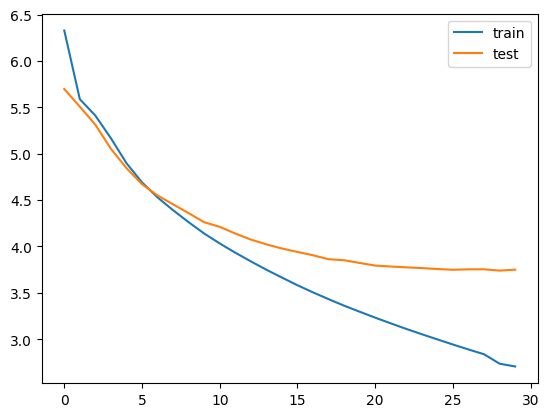

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# 저장된 가중치 로드
model.load_weights('best_transformer_weights.weights.h5')

### 실제 결과와 요약문 비교하기(추상적 요약)

In [ ]:
# 주요 변수 확인 및 매핑
src_index_to_word = src_tokenizer.index_word  # 원문 단어 집합에서 정수 -> 단어
tar_word_to_index = tar_tokenizer.word_index  # 요약 단어 집합에서 단어 -> 정수
tar_index_to_word = tar_tokenizer.index_word  # 요약 단어 집합에서 정수 -> 단어

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LayerNormalization
# 레퍼런스 인코더 입력과 출력
encoder_inputs = model.input[0]  # encoder_inputs
encoder_outputs = model.get_layer(name="encoder_layer_3").output  # 최종 출력 인코더

# 인코더 모델
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_outputs)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LayerNormalization, Lambda

# 디코더 입력 정의
decoder_inputs = Input(shape=(1,), name="decoder_inputs_test")  # decoder_inputs_test
encoder_outputs_input = Input(shape=(50, 128), name="encoder_outputs_test")  # 받아올 인코더 출력

# 디코더 임베딩 & 포지셔널 임베딩
decoder_embedding_layer = model.get_layer(name="embedding_6")  # 디코더 임베딩
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_pos_encoding = positional_encoding(1, 128)  # 포지셔널 인코딩
decoder_outputs = decoder_embedding + decoder_pos_encoding

# 람다로 안 묶어주면 케라스 환경 어쩌고 하면서 에러가 난다.
# Look-Ahead Mask와 Padding Mask 생성 (Lambda를 사용하여 처리)
look_ahead_mask = Lambda(lambda _: create_look_ahead_mask(1))(decoder_inputs)
padding_mask = Lambda(lambda seq: create_padding_mask(seq))(decoder_inputs)
combined_mask = Lambda(lambda masks: tf.maximum(masks[0], masks[1]))([look_ahead_mask, padding_mask])

# 디코더 레이어
for i in range(4):  # 총 4개
    decoder_layer = model.get_layer(name=f"decoder_layer_{i}")  # 디코더
    mha_layer = model.get_layer(name=f"multi_head_attention_{21 + i * 2}")  # 멀티헤드 어텐션

    # 디코더의 Self-Attention에 마스킹 추가 다음꺼 참조 못하게
    decoder_outputs = decoder_layer(decoder_outputs, mask=combined_mask)

    # 멀티헤드 어텐션 (쿼리=디코더 출력, 키/값=인코더 출력)
    attention_output = mha_layer(
        q=decoder_outputs,
        k=encoder_outputs_input,
        v=encoder_outputs_input
    )

    # Add & Normalize 이것도 공부 좀
    decoder_outputs = LayerNormalization(epsilon=1e-6)(decoder_outputs + attention_output)

# 최종 Dense
final_output = model.get_layer(name="final_dense")(decoder_outputs)

# 디코더 모델
decoder_model = Model(inputs=[decoder_inputs, encoder_outputs_input], outputs=final_output)

In [ ]:
# 4차

def decode_sequence(input_seq, return_tokens=False):
    """
    입력 문장(input_seq)을 받아 인코더와 디코더를 통해 요약문 생성
    """
    # 1. 인코더를 통해 입력 문장의 출력 생성
    encoder_output = encoder_model.predict(input_seq)

    # 2. 디코더의 시작 토큰을 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index['sostoken']  # 시작 토큰

    # 3. 디코더를 반복적으로 호출하여 요약문 생성
    stop_condition = False
    decoded_sentence = []
    decoded_tokens = []

    while not stop_condition:
        # 디코더를 호출하여 출력 생성
        output_tokens = decoder_model.predict([target_seq, encoder_output])

        # 가장 확률이 높은 단어의 인덱스를 선택
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        decoded_tokens.append(sampled_token_index)

        # 종료 조건 확인
        if (sampled_token_index == tar_word_to_index['eostoken'] or
                len(decoded_sentence) >= (summary_max_len - 1)):
            stop_condition = True
        else:
            # 인덱스를 단어로 변환
            sampled_token = tar_index_to_word.get(sampled_token_index, '<UNK>')
            decoded_sentence.append(sampled_token)

        # 디코더 입력 갱신
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    if return_tokens:
        return decoded_tokens
    return ' '.join(decoded_sentence).strip()

In [ ]:
# 5차

def decode_sequence(input_seq, return_tokens=False):
    """
    입력 문장(input_seq)을 받아 인코더와 디코더를 통해 요약문 생성
    """
    # 1. 인코더를 통해 입력 문장의 출력 생성
    encoder_output = encoder_model.predict(input_seq)

    # 2. 디코더의 시작 토큰을 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index['sostoken']  # 시작 토큰

    # 3. 디코더를 반복적으로 호출하여 요약문 생성
    stop_condition = False
    decoded_sentence = []
    decoded_tokens = []

    while not stop_condition:
        # 디코더를 호출하여 출력 생성
        output_tokens = decoder_model.predict([target_seq, encoder_output])

        # 가장 확률이 높은 단어의 인덱스를 선택
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        decoded_tokens.append(sampled_token_index)

        # 종료 조건 확인
        if (sampled_token_index == tar_word_to_index['eostoken'] or
                len(decoded_sentence) >= (summary_max_len - 1)):
            stop_condition = True
        else:
            # 인덱스를 단어로 변환하여 문장에 추가
            sampled_token = tar_index_to_word.get(sampled_token_index, '<UNK>')
            decoded_sentence.append(sampled_token)

        # 디코더 입력 갱신
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    if return_tokens:
        return decoded_tokens
    return ' '.join(decoded_sentence).strip()

In [ ]:
def seq2text(input_seq):
    return ' '.join([src_index_to_word.get(i, '<UNK>') for i in input_seq if i != 0])

def seq2summary(input_seq):
    return ' '.join([
        tar_index_to_word.get(i, '<UNK>')
        for i in input_seq
        if i != 0 and i not in {tar_word_to_index['sostoken'], tar_word_to_index['eostoken']}
    ])

In [ ]:
for i in range(14):
    print(f"원문 ({i}):", seq2text(encoder_input_test[i]))
    print(f"실제 요약 ({i}):", seq2summary(decoder_target_test[i]))
    print(f"예측 요약 ({i}):", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 (0): haryana year old pranav goyal sunday topped jee advanced exam scoring marks alumnus bhavan vidyalaya panchkula goyal scored cbse class exams secured india rank jee mains scored marks jee mains
실제 요약 (0): who is <UNK> goyal the jee advanced topper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
예측 요약 (0): haryana tops jee topper jee topper jee topper jee topper jee


원문 (1): prime minister narendra modi wrote letter gujarat couple defended rafale deal wedding card noticed unique feature marriage invitation card sent guests also inspires keep

# ..뭐든 시도에 의의가 있는 법이다.
## 그래도 핵심 토큰은 잘 집어넣긴 했다. 문법적으로 오류가 많아서 그렇지.
 * 디코더에서 중요 문장에 집중도를 제한하거나 아니면 아예 단어 수에 제한 걸어버리면 그나마 깔끔할 것 같다.
 * 중복 단어가 뒤에 쭉 이어지는데, 내 생각엔 중요도가 높다고 판단한 단어를 계속 내뱉는 경향이 있는 것 같다.
 * 아니면, 패딩 쪽을 마스킹을 잘 못해서 학습에 영향을 줬나 싶기도 하다.

### Summa을 이용해서 추출적 요약해보기

In [ ]:
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=8f834fbece364d83046b5652718824340b14d5a16149dc624e673d62035b70bc
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [ ]:
data.head()

,headlines,text,decoder_input,decoder_target,decoder_conbined
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...


In [ ]:
import summa
from summa import summarizer
from summa.summarizer import summarize
print(version('summa'))

1.2.0


In [ ]:
data['text'][1111]

'traders body cait urged commerce minister suresh prabhu probe amazon samara capital acquisition billionaire kumar mangalam birla supermarket chain cait claims deal circumvents revised fdi policy commerce wants stay deal till probe conducted comes cci approved acquisition friday'

In [ ]:
# 각 행별 문자열 길이 계산
data['text_length'] = data['text'].apply(len)

# 길이를 기준으로 상위 10개 정렬
top_10_rows = data.nlargest(20, 'text_length')

# 결과 출력
print(top_10_rows[['text', 'text_length']])

                                                    text  text_length
12302  drive next generation experiencechange says br...          370
11094  british bank hsbc executed india first oversea...          365
15892  bajaj allianz life launched critical illness p...          360
19959  several guests suffered uncontrollable diarrho...          360
379    maharashtra navnirman sena president raj thack...          358
428    nissan kicks recently launched india equipped ...          355
83623  us president donald trump russian president vl...          352
29238  allen solly india pioneer brand unconventional...          351
12971  dussehra reliance general insurance urges peop...          348
75187  prime minister narendra modi thanked world lea...          347
6987   maharashtra electricity regulator formed two m...          346
9224   chennai based iot startup detect technologies ...          346
10277  volkswagen recently launched volkswagen connec...          346
21644  automaker her

In [ ]:
# 첫번째행
text_to_summarize = data['text'][379]
summary = summarizer.summarize(text_to_summarize, ratio=0.3,words=10)

# 요약이 비어있음?
if summary:
    print("headlines:")
    print(summary)
else:
    print("요약없음")

요약없음


### 요약하려는 문장이 너무 짧다. 아래 정도는 되어야 요약이 잘 일어나는데.

In [ ]:
# 첫번째행만
text_to_summarize = 'In many Western countries, a question you should never ask in the first encounter with someone is his or her age. Among many Koreans, however, asking such sensitive personal information is a common way to start a conversation. Identifying a person’s age is a must-do process. Although I found it to be quite rude or sometimes offensive at first, I soon realized the logic behind it : to respect the elders and to classify the person. In the Western world, age is considered by many to be only a number. Many Westerners believe each person has a different way of life andage should not be considered as a major factor for doing what he or she desires in life. Many Westerners tend to judge you by your behavior before they know how old you are. In Korea, it is exactly the opposite. Koreans want to know your age first, and then what kind of person you are. It seems a person’s age is the most single important factor when judging a person. By conservative Korean tradition, you must pay unconditional respect by using respectful words to a person older than you. As a Korean who was raised in England, I personally think it is a great Confucian tradition to show respect to someone, especially for elders. However, a false stereotype and negative media portrayal have implanted a wrong social value and public perception toward age in Korean society today. In England, I went to school with people of various nationalities, backgrounds, cultures and ages. I especially learned so much from mature students in their 30s and 40s. They had so much to offer and I was always intrigued by their life experience and wisdom. I wish Korean colleges and universities opened up for more mature students. Younger people need to be exposed more to people from various walks of life. They need to understand that aging is not simply a process of becoming old and age should not be a barrier in starting a friendship. Maturity and wisdom also go with it. The same goes for the elders too Elders need to understand that respect should be earned not given. Instead of only correcting the misbehavior of youngsters, elders need to understand and to talk with youngsters to narrow the gap. Trying to become a friend with them is of the utmost importance.'
# 요약
summary = summarizer.summarize(text_to_summarize, ratio=0.4,words=50)

# 요약이 비어있음?
if summary:
    print("headlines:")
    print(summary)
else:
    print("요약없음")

headlines:
Koreans want to know your age first, and then what kind of person you are.
It seems a person’s age is the most single important factor when judging a person.
As a Korean who was raised in England, I personally think it is a great Confucian tradition to show respect to someone, especially for elders.


### 표를 만들기는 힘들 것 같고 1개만 비교해보자.
#### 우연하게 LSM환경에서 얻어걸린 조합이 있다. 버전 문제인지 동일한 조건인데 코랩에서는 안된다.

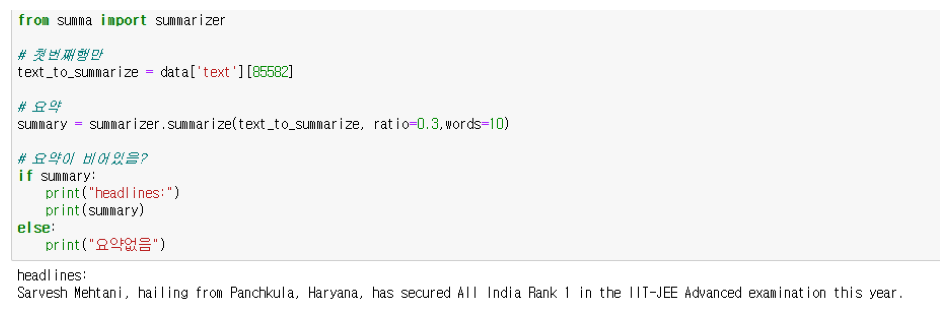

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

image_path = '/content/drive/MyDrive/aiffel/Data/lms.png'

# 이미지 불러오기
image = Image.open(image_path)

# 확대하여 이미지 표시
plt.figure(figsize=(12, 12))  # figsize로 크기 조정 (여기서 숫자를 더 크게 조정 가능)
plt.imshow(image)
plt.axis('off')  # 축 숨기기
plt.show()

#### 아래는 셔플된 데이터에서 트랜스포머로 추상한 첫번째 원문 요약이다
* 실제 요약 : who is <UNK> goyal the jee advanced topper
* 추상적 예측 요약 : haryana tops jee topper jee topper jee topper jee topper jee
* 추출적 예측 요약 : Sarvesh Mehtani, hailing from Panchkula, Haryana, has secured All India Rank 1 in the IIT-JEE Advanced examination this year.

* 추상적 요약은 topper와 jee를 추정해냈다.
* 반면에 추출적 요약은 굉장히 세부적인 내용에 국한되어 있는듯 싶다.